#### Aim: To optimise the the receiver confguration and source location to minimise the error.

In each configuration, the error is computed as $$\theta = (\Delta r - r + r_1)^T.(\Delta r - r + r_1) + (s-s^o)^T.(s-s^o)$$
where r denotes time recorded, s denotes position of receivers. 

Since the correct position of receivers is unknown. We'll be ignoring the second term here. We'll set iterations a bit differently this time.( As compared to source_localization_TDOA).The function for such scenario is already there in source_localization_TDOA.

 Now, there are several ways to vary the receiver configuration:
 
1. Vary the receiver location randomly after a  given number of iterations for source location. (method suggested by Bharath sir)
2. Assign a particular configuration to receivers (randomly), completely iterate over the domain for source location as described above. Repeat this a great number of times, aggregate and compare the results.

3. A slight modification of method 1, after each step for source location, choose a random receiver and move it to reduce the error or propose a slight shift in a particular receivers' position, check the change I error, choose to shift the receiver if error is decreased.


In [1]:
# importing the requiered libraries

import numpy as np
import matplotlib.pyplot as plt
from numba import jit


In [2]:
def src_Loc(rec_pos, t_rec,c,src_pos):
    '''The function returns the difference between the position of source(guessed) and receiver location as calculated from 
    measurement of time difference of arrival with the distance calculated from position of source and receiver. We aim to 
    minimise this quantity

    rec_pos = a matrix with position of receivers stored in the following format [[x_1, y_1],[x_2,y_2]]
    t_rec  = the time of arrival as measured from data
    source_loc = the guessed source location for which the function is being evaluated
    
    '''
    
    n_rec = np.shape(rec_pos)[0]
    t_rec_rel1 = np.zeros(shape=(n_rec-1,1))   # time difference calculated wrt the value in first receiver
    
    t_rec_rel1[:] = t_rec[1:] -t_rec[0]     
    
    rec_pos_src_rel = np.zeros(shape =(n_rec-1,2)) # Calculating the relative position of recivers wrt the source
    
    rec_pos_src_rel[:] = rec_pos[1:] -src_pos*np.ones_like(rec_pos_src_rel)  # relative position of receiver 1 wrt the source
    
    rec1_pos_src_rel = rec_pos[0] -src_pos # the position of receiver one wrt the source
    
    rec_dist_src_rel = np.zeros(shape=(n_rec-1,1))
    
    rec1_dist_src_rel = np.sqrt(rec1_pos_src_rel[0]**2 + rec1_pos_src_rel[1]**2)
    
    rec_dist_src_rel[:] = np.sqrt(rec_pos_src_rel[:,0]**2 + rec_pos_src_rel[:,1]**2).reshape(n_rec-1,1)
    
    delta_r = t_rec_rel1*c
    
    error = np.zeros(shape =(n_rec-1,1))   # defing the error to be minimized
    error[:] = delta_r[:] - (rec_dist_src_rel[:]-rec1_dist_src_rel)   
    
    error_to_min =np.dot(error.T,error) # Getting a single value instead of an array
    
    return error_to_min
        

The above function works without the hassle of true receiver locations. Whatever our guess is we'll take it to be true.

In [3]:
# Testing out with 101 receivers placed in a line

rec_pos_act= np.zeros(shape =(101,2))  # Assigning thr actual receiver position
rec_pos_act[:,:] = 0 # The deployer is at origin. 
noise_r = np.random.normal(loc=0.0,scale =100,size = (101,2))
t_rec_ideal = np.zeros(shape =(101,1))  # ideal value at receivers
rec_pos_mes= rec_pos_act +noise_r   
t_rec_ideal[0:101] = np.sqrt((rec_pos_mes[0:101,1]-100)**2 + (rec_pos_mes[0:101,0]-100)**2).reshape(101,1)
noise_t = np.random.normal(loc=0.0,scale =0.2,size = (101,1))
t_Rec_real = t_rec_ideal + noise_t

c = 1 # velocity of propagation

# Note the different order in which the noises are added this time. 

Text(0.5, 1.0, 'Error contour for receivers with error in both time of arrival and known position')

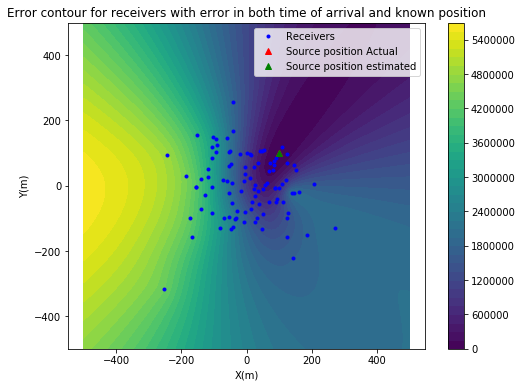

In [4]:
# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(1000,1000))  # To store the values at various points
rec_pos_modified = np.zeros_like(rec_pos_act)
rec_pos_modified[:] = rec_pos_act[:]  # Can modify later if required
for i in range(1000):
    for j in range(1000):
        error[i,j] = src_Loc(rec_pos=rec_pos_mes,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

The above result was for the correct configuration. Trying to run with different configuration. First by error addition, second by another random configuration.

In [5]:
# Testing out with 101 receivers placed in a line

rec_pos_act= np.zeros(shape =(101,2))  # Assigning thr actual receiver position
rec_pos_act[:,:] = 0 # The deployer is at origin. 
noise_r = np.random.normal(loc=0.0,scale =100,size = (101,2))
t_rec_ideal = np.zeros(shape =(101,1))  # ideal value at receivers
rec_pos_mes= rec_pos_act +noise_r   
t_rec_ideal[0:101] = np.sqrt((rec_pos_mes[0:101,1]-100)**2 + (rec_pos_mes[0:101,0]-100)**2).reshape(101,1)
noise_t = np.random.normal(loc=0.0,scale =0.2,size = (101,1))
t_Rec_real = t_rec_ideal + noise_t

c = 1 # velocity of propagation

# Note the different order in which the noises are added this time. 

Text(0.5, 1.0, 'Error contour for receivers with error in both time of arrival and known position')

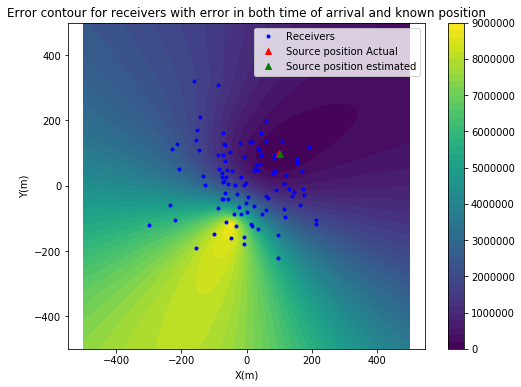

In [6]:
# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(1000,1000))  # To store the values at various points
noise_r_add = np.random.normal(loc=0.0,scale =10,size = (101,2))
rec_pos_est = np.zeros_like(rec_pos_act)
rec_pos_est[:] = rec_pos_mes[:]  + noise_r_add[:]
for i in range(1000):
    for j in range(1000):
        error[i,j] = src_Loc(rec_pos=rec_pos_est,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

We see with a 10% error, the source location is still calculated quite nicely. Let's now choose a random configuration and see how it fits

In [7]:
# Testing out with 101 receivers placed in a line

rec_pos_act= np.zeros(shape =(101,2))  # Assigning thr actual receiver position
rec_pos_act[:,:] = 0 # The deployer is at origin. 
noise_r = np.random.normal(loc=0.0,scale =100,size = (101,2))
t_rec_ideal = np.zeros(shape =(101,1))  # ideal value at receivers
rec_pos_mes= rec_pos_act +noise_r   
t_rec_ideal[0:101] = np.sqrt((rec_pos_mes[0:101,1]-100)**2 + (rec_pos_mes[0:101,0]-100)**2).reshape(101,1)
noise_t = np.random.normal(loc=0.0,scale =0.2,size = (101,1))
t_Rec_real = t_rec_ideal + noise_t

c = 1 # velocity of propagation

# Note the different order in which the noises are added this time. 

Text(0.5, 1.0, 'Error contour for receivers with error in both time of arrival and known position')

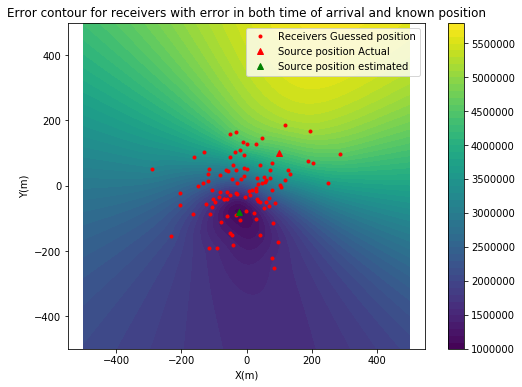

In [8]:
# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(1000,1000))  # To store the values at various points
noise_r_add = np.random.normal(loc=0.0,scale =100,size = (101,2))
rec_pos_est = np.zeros_like(rec_pos_act)
rec_pos_est[:] = rec_pos_act[:]  + noise_r_add[:]
for i in range(1000):
    for j in range(1000):
        error[i,j] = src_Loc(rec_pos=rec_pos_est,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
#plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers actual position')
plt.plot(rec_pos_est[:,0],rec_pos_est[:,1],'r.',label='Receivers Guessed position')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

As expeted, we have quite a bit deviation in source location estimated since, the receiver positions are guessed only. Let's try something else. Let us try to alter the receiver positon for each iteration.

In [9]:
# Testing out with 101 receivers placed in a line

rec_pos_act= np.zeros(shape =(101,2))  # Assigning thr actual receiver position
rec_pos_act[:,:] = 0 # The deployer is at origin. 
noise_r = np.random.normal(loc=0.0,scale =100,size = (101,2))
t_rec_ideal = np.zeros(shape =(101,1))  # ideal value at receivers
rec_pos_mes= rec_pos_act +noise_r   
t_rec_ideal[0:101] = np.sqrt((rec_pos_mes[0:101,1]-100)**2 + (rec_pos_mes[0:101,0]-100)**2).reshape(101,1)
noise_t = np.random.normal(loc=0.0,scale =0.2,size = (101,1))
t_Rec_real = t_rec_ideal + noise_t

c = 1 # velocity of propagation

# Note the different order in which the noises are added this time. 

In [10]:
# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(1000,1000))  # To store the values at various points
for i in range(1000):
    for j in range(1000):
        noise_r_add = np.random.normal(loc=0.0,scale =100,size = (101,2))
        rec_pos_est = np.zeros_like(rec_pos_act)
        rec_pos_est[:] = rec_pos_act[:]  + noise_r_add[:]
        error[i,j] = src_Loc(rec_pos=rec_pos_est,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
#plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers actual position')
plt.plot(rec_pos_est[:,0],rec_pos_est[:,1],'b.',label='Receivers Guessed position')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

KeyboardInterrupt: 

We see that the picture is quite mixed and nothing further can be told except that errors throughout thev domain appear to not to be in any pattern and the variation is quite random. 

In [ ]:
# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(1000,1000))  # To store the values at various points
for i in range(1000):
    for j in range(1000):
        if (i+j)%5==0 :# Just a generator to pick selectively, when to change position
            noise_r_add = np.random.normal(loc=0.0,scale =100,size = (101,2))
            rec_pos_est = np.zeros_like(rec_pos_act)
            rec_pos_est[:] = rec_pos_act[:]  + noise_r_add[:]
        error[i,j] = src_Loc(rec_pos=rec_pos_est,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
#plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers actual position')
plt.plot(rec_pos_est[:,0],rec_pos_est[:,1],'b.',label='Receivers Guessed position')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

Not much difference is observed from the previous plt except less frequent visibility of medium error regions.(light blue color). Modifying it to picj larger number of steps between receiver position change.

In [ ]:
# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(1000,1000))  # To store the values at various points
for i in range(1000):
    for j in range(1000):
        if (i+j)%100 ==0 :# Just a generator to pick selectively, when to change position
            noise_r_add = np.random.normal(loc=0.0,scale =100,size = (101,2))
            rec_pos_est = np.zeros_like(rec_pos_act)
            rec_pos_est[:] = rec_pos_act[:]  + noise_r_add[:]
        error[i,j] = src_Loc(rec_pos=rec_pos_est,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
#plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers actual position')
plt.plot(rec_pos_est[:,0],rec_pos_est[:,1],'b.',label='Receivers Guessed position')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

Nothing of note occurs except that the medium error regions are now strips instead of points. Degrading the update rate a bit more.

In [ ]:
# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(1000,1000))  # To store the values at various points
for i in range(1000):
    for j in range(1000):
        if (i+j)%1000 ==0 :# Just a generator to pick selectively, when to change position
            noise_r_add = np.random.normal(loc=0.0,scale =100,size = (101,2))
            rec_pos_est = np.zeros_like(rec_pos_act)
            rec_pos_est[:] = rec_pos_act[:]  + noise_r_add[:]
        error[i,j] = src_Loc(rec_pos=rec_pos_est,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
#plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers actual position')
plt.plot(rec_pos_est[:,0],rec_pos_est[:,1],'b.',label='Receivers Guessed position')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

As expected, we find that the strips become longer(more numbers are possible with sum 1000 which occur in a sequence).

We find that the first method doesn;t work well by random change. A better way is to propose change in one receivers position, if that leads to decrease in error accept it else reject it. (Idea borrowed from Ising model simulation using Markov Chain Monte Carlo methods.)

In [ ]:
# A typical trial with uncertainity in position as large as the spread

# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(1000,1000))  # To store the values at various points
noise_r_add = np.random.normal(loc=0.0,scale =100,size = (101,2))
rec_pos_est = np.zeros_like(rec_pos_act)
rec_pos_est[:] = rec_pos_act[:]  + noise_r_add[:]

for i in range(1000):
    for j in range(1000):
        error[i,j] = src_Loc(rec_pos=rec_pos_est,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
#plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers actual position')
plt.plot(rec_pos_est[:,0],rec_pos_est[:,1],'b.',label='Receivers Guessed position')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

In [ ]:
# A typical trial with uncertainity in position as large as the spread

# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(1000,1000))  # To store the values at various points
noise_r_add = np.random.normal(loc=0.0,scale =10,size = (101,2))
rec_pos_est = np.zeros_like(rec_pos_act)
rec_pos_est[:] = rec_pos_mes[:]  + noise_r_add[:]


for i in range(1000):
    for j in range(1000):
        
        error[i,j] = src_Loc(rec_pos=rec_pos_est,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))        
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
#plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers actual position')
plt.plot(rec_pos_est[:,0],rec_pos_est[:,1],'b.',label='Receivers Guessed position')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

This is just one example where a 10% noise of standard deviation of spread of the receivers, the results are not effected by much.

In [ ]:
# A typical trial with uncertainity in position as large as the spread

# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(1000,1000))  # To store the values at various points
noise_r_add = np.random.normal(loc=0.0,scale =100,size = (101,2))
rec_pos_est = np.zeros_like(rec_pos_act)
rec_pos_est[:] = rec_pos_mes[:]  + noise_r_add[:]


for i in range(1000):
    for j in range(1000):
        
        error[i,j] = src_Loc(rec_pos=rec_pos_est,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))        
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
#plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers actual position')
plt.plot(rec_pos_est[:,0],rec_pos_est[:,1],'b.',label='Receivers Guessed position')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

#### Trying markov chain Monte Carlo method to improve this result. 

In markov chain monte carlo, we first calculate the error as we have done before then, we tweak the position of a random receiver and determine whether it leads to improvement in the the source position estimation.

In [17]:
# A typical trial with uncertainity in position as large as the spread

# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:100j,-500:500:100j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(100,100))
error2 = np.zeros(shape=(100,100))
# To store the values at various points
noise_r_add = np.random.normal(loc=0.0,scale =100,size = (101,2))
rec_pos_est = np.zeros_like(rec_pos_act)
rec_pos_est2 = np.zeros_like(rec_pos_act)
rec_pos_est[:] = rec_pos_act[:]  + noise_r_add[:]
rec_pos_est2[:] = rec_pos_est[:]

#@jit(nopython=True)  # this speeds up the computation
for k in range(100):
    rec_no = np.random.randint(low=0,high=101,size=20)
    rec_pos_est2[rec_no[0],:] = rec_pos_est2[rec_no[0],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[1],:] = rec_pos_est2[rec_no[1],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[2],:] = rec_pos_est2[rec_no[2],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[3],:] = rec_pos_est2[rec_no[3],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[4],:] = rec_pos_est2[rec_no[4],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[5],:] = rec_pos_est2[rec_no[5],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[6],:] = rec_pos_est2[rec_no[6],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[7],:] = rec_pos_est2[rec_no[7],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[8],:] = rec_pos_est2[rec_no[8],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[9],:] = rec_pos_est2[rec_no[9],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[10],:] = rec_pos_est2[rec_no[0],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[11],:] = rec_pos_est2[rec_no[1],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[12],:] = rec_pos_est2[rec_no[2],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[13],:] = rec_pos_est2[rec_no[3],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[14],:] = rec_pos_est2[rec_no[4],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[15],:] = rec_pos_est2[rec_no[5],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[16],:] = rec_pos_est2[rec_no[6],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[17],:] = rec_pos_est2[rec_no[7],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[18],:] = rec_pos_est2[rec_no[8],:] + np.random.randint(low=1,high =20,size =2)
    rec_pos_est2[rec_no[19],:] = rec_pos_est2[rec_no[9],:] + np.random.randint(low=1,high =20,size =2)
    
    for i in range(100):
        for j in range(100):
            error[i,j] = src_Loc(rec_pos=rec_pos_est,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
            Error_1 = np.sum(error) 
            error2[i,j] = src_Loc(rec_pos=rec_pos_est2,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
            Error_2 =np.sum(error2)
    
    if Error_2 < Error_1:
        rec_pos_est[:] = rec_pos_est2[:] 
    print(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))])
            #now switching the position of receiver
    '''plt.figure(figsize=(8,6))
    plt.contourf(x,y,error,levels=50)
    #plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers actual position')
    plt.plot(rec_pos_est[:,0],rec_pos_est[:,1],'b.',label='Receivers Guessed position')
    plt.plot(100,100,'r^',label='Source position Actual')
    plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
    plt.plot()
    plt.legend()
    plt.xlim(-500,500)
    plt.ylim(-500,500)
    plt.xlabel('X(m)')
    plt.ylabel('Y(m)')
    plt.axis('equal')
    plt.colorbar()
    plt.title('Error contour for receivers with error in both time of arrival and known position')'''

[15.15151515] [-65.65656566]
[15.15151515] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.65656566]
[5.05050505] [-65.

Now after this is done, let's return to sampling and analysing data with multiple configurations. We'll draw conclusions regarding only time error and regarding position error tolerability. Let's say we can tolerate a difference of arounf 25m in source position. The velocity used here will be in km/s. 